# 0. Setup

In [1]:
import pandas as pd
import pickle
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [3]:
# Data folders

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FE7B4BA0", alpha=0.2, label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FE7B4BA0", alpha=0.2, label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FE7B4BA0", alpha=0.2, label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FB3B38", alpha=0.2, label='Energy-price crisis')
    }

In [5]:
# Load the data
file_name = "clean_data.csv"
file_path = processed_data_dir / file_name
df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
df = df.resample('ME').last()
assert df.isna().sum().sum() == 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2015-01-31 to 2025-07-31
Freq: ME
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   online_retail_sales_share  127 non-null    float64
 1   cpi_inf                    127 non-null    float64
 2   rpi_ex_cpi                 127 non-null    float64
 3   eff_fx_inf                 127 non-null    float64
 4   cci                        127 non-null    float64
 5   boe_rate                   127 non-null    float64
dtypes: float64(6)
memory usage: 6.9 KB


# 1. Changepoints analysis

## Seasonality

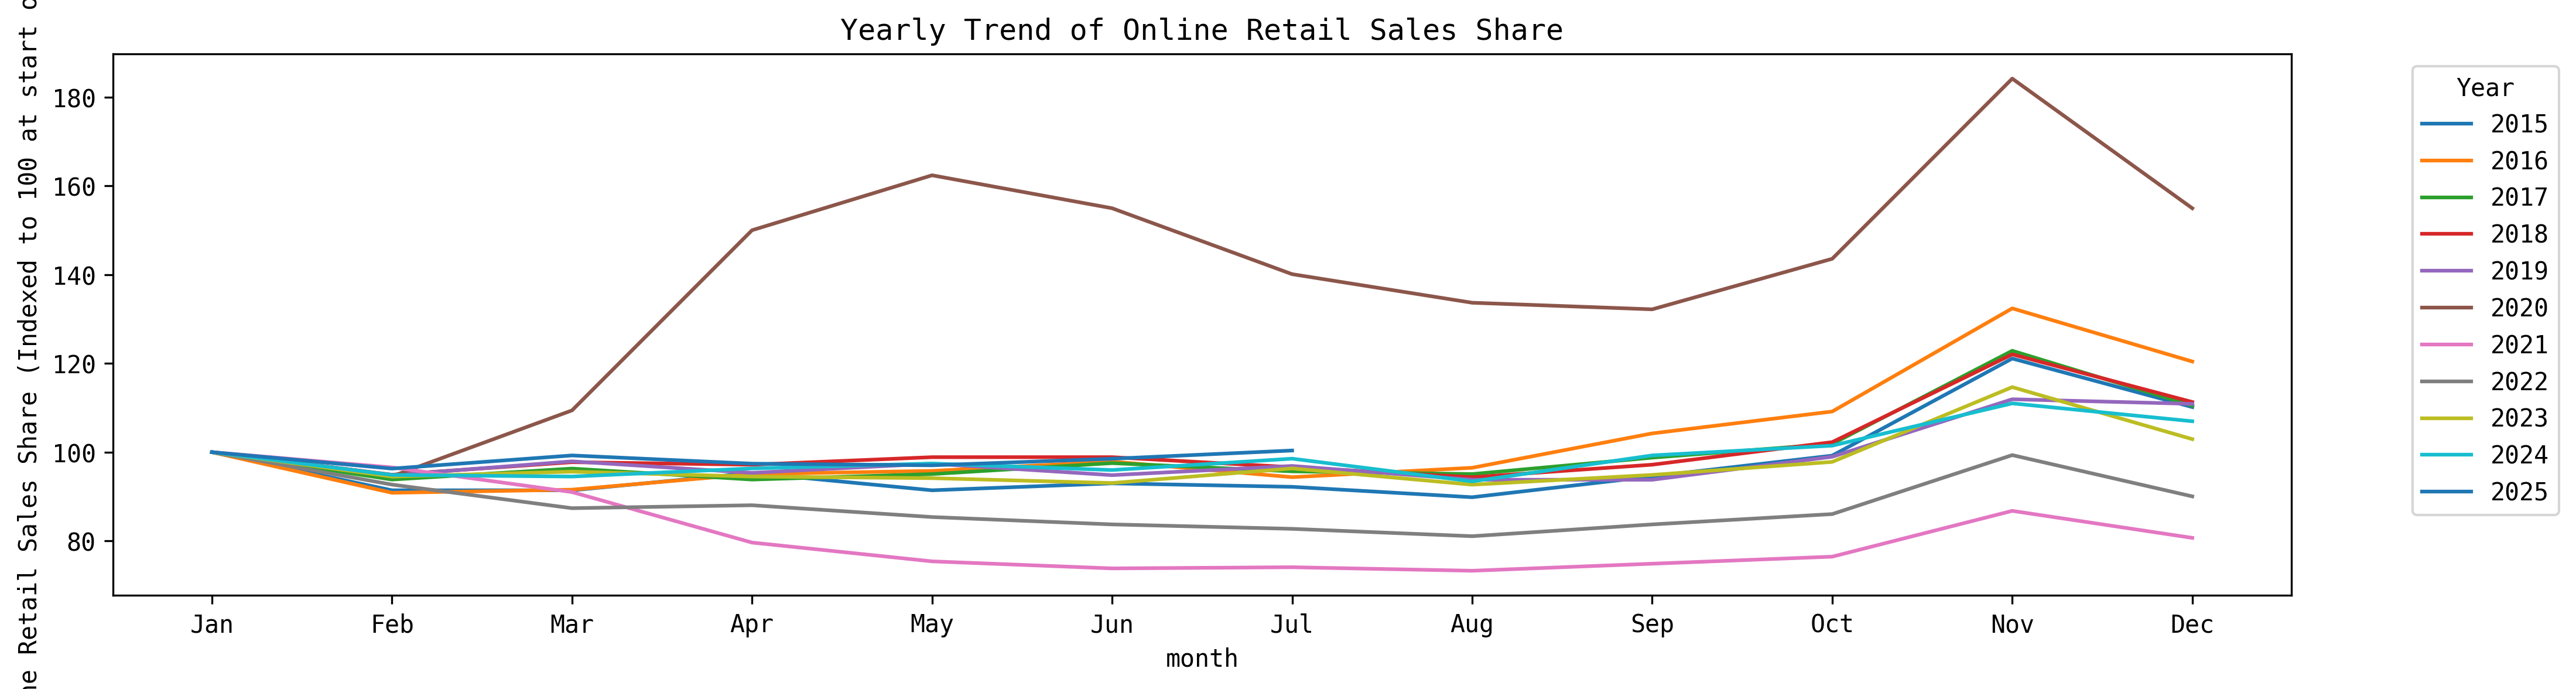

In [6]:
plot_data = df.copy()
plot_data.reset_index(inplace=True)
plot_data['year'] = plot_data['date'].dt.year
plot_data['month'] = plot_data['date'].dt.month
plot_data['day'] = plot_data['date'].dt.day

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
for year in plot_data['year'].unique():
    yearly_data = plot_data[plot_data['year'] == year]
    yearly_data = yearly_data.sort_values(by='date')
    # Normalize to 100 at the start of the year
    yearly_data['normalized_sales_share'] = yearly_data['online_retail_sales_share'] / yearly_data['online_retail_sales_share'].iloc[0] * 100
    sns.lineplot(data=yearly_data, x='month', y='normalized_sales_share', label=str(year), ax=ax)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Online Retail Sales Share (Indexed to 100 at start of year)')
ax.set_title('Yearly Trend of Online Retail Sales Share')
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [7]:
# calculate seasonal component and its strength
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['online_retail_sales_share'], model='additive')
seasonal_component = decomposition.seasonal
seasonal_variance = seasonal_component.var()
total_variance = df['online_retail_sales_share'].var()
seasonal_strength_v1 = seasonal_variance / total_variance
print(f"Seasonal strength (variance ratio): {seasonal_strength_v1:.4f}")

Seasonal strength (variance ratio): 0.0349


>Note: weak seasonality

## Stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss
adf_diff_0 = adfuller(df['online_retail_sales_share'])
adf_diff_1 = adfuller(df['online_retail_sales_share'].diff().dropna())
adf_diff_2 = adfuller(df['online_retail_sales_share'].diff().diff().dropna())
kpss_diff_0 = kpss(df['online_retail_sales_share'])
kpss_diff_1 = kpss(df['online_retail_sales_share'].diff().dropna())
kpss_diff_2 = kpss(df['online_retail_sales_share'].diff().diff().dropna())
print('Diff 0: ADF p-value:', adf_diff_0[1], 'KPSS p-value:', kpss_diff_0[1])
print('Diff 1: ADF p-value:', adf_diff_1[1], 'KPSS p-value:', kpss_diff_1[1])
print('Diff 2: ADF p-value:', adf_diff_2[1], 'KPSS p-value:', kpss_diff_2[1])

Diff 0: ADF p-value: 0.4396603310709866 KPSS p-value: 0.01
Diff 1: ADF p-value: 0.12761775664388425 KPSS p-value: 0.1
Diff 2: ADF p-value: 1.1496685177132525e-12 KPSS p-value: 0.1


/tmp/ipykernel_59980/3557598270.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_diff_0 = kpss(df['online_retail_sales_share'])
/tmp/ipykernel_59980/3557598270.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_diff_1 = kpss(df['online_retail_sales_share'].diff().dropna())
/tmp/ipykernel_59980/3557598270.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_diff_2 = kpss(df['online_retail_sales_share'].diff().diff().dropna())


In [9]:
"""
from arch.unitroot import PhillipsPerron, DFGLS
# Phillips-Perron test (more robust to heteroskedasticity)
pp_test = PhillipsPerron(df['online_retail_sales_share'].diff().dropna())
print(f"PP test p-value: {pp_test.pvalue}")
"""

'\nfrom arch.unitroot import PhillipsPerron, DFGLS\n# Phillips-Perron test (more robust to heteroskedasticity)\npp_test = PhillipsPerron(df[\'online_retail_sales_share\'].diff().dropna())\nprint(f"PP test p-value: {pp_test.pvalue}")\n'

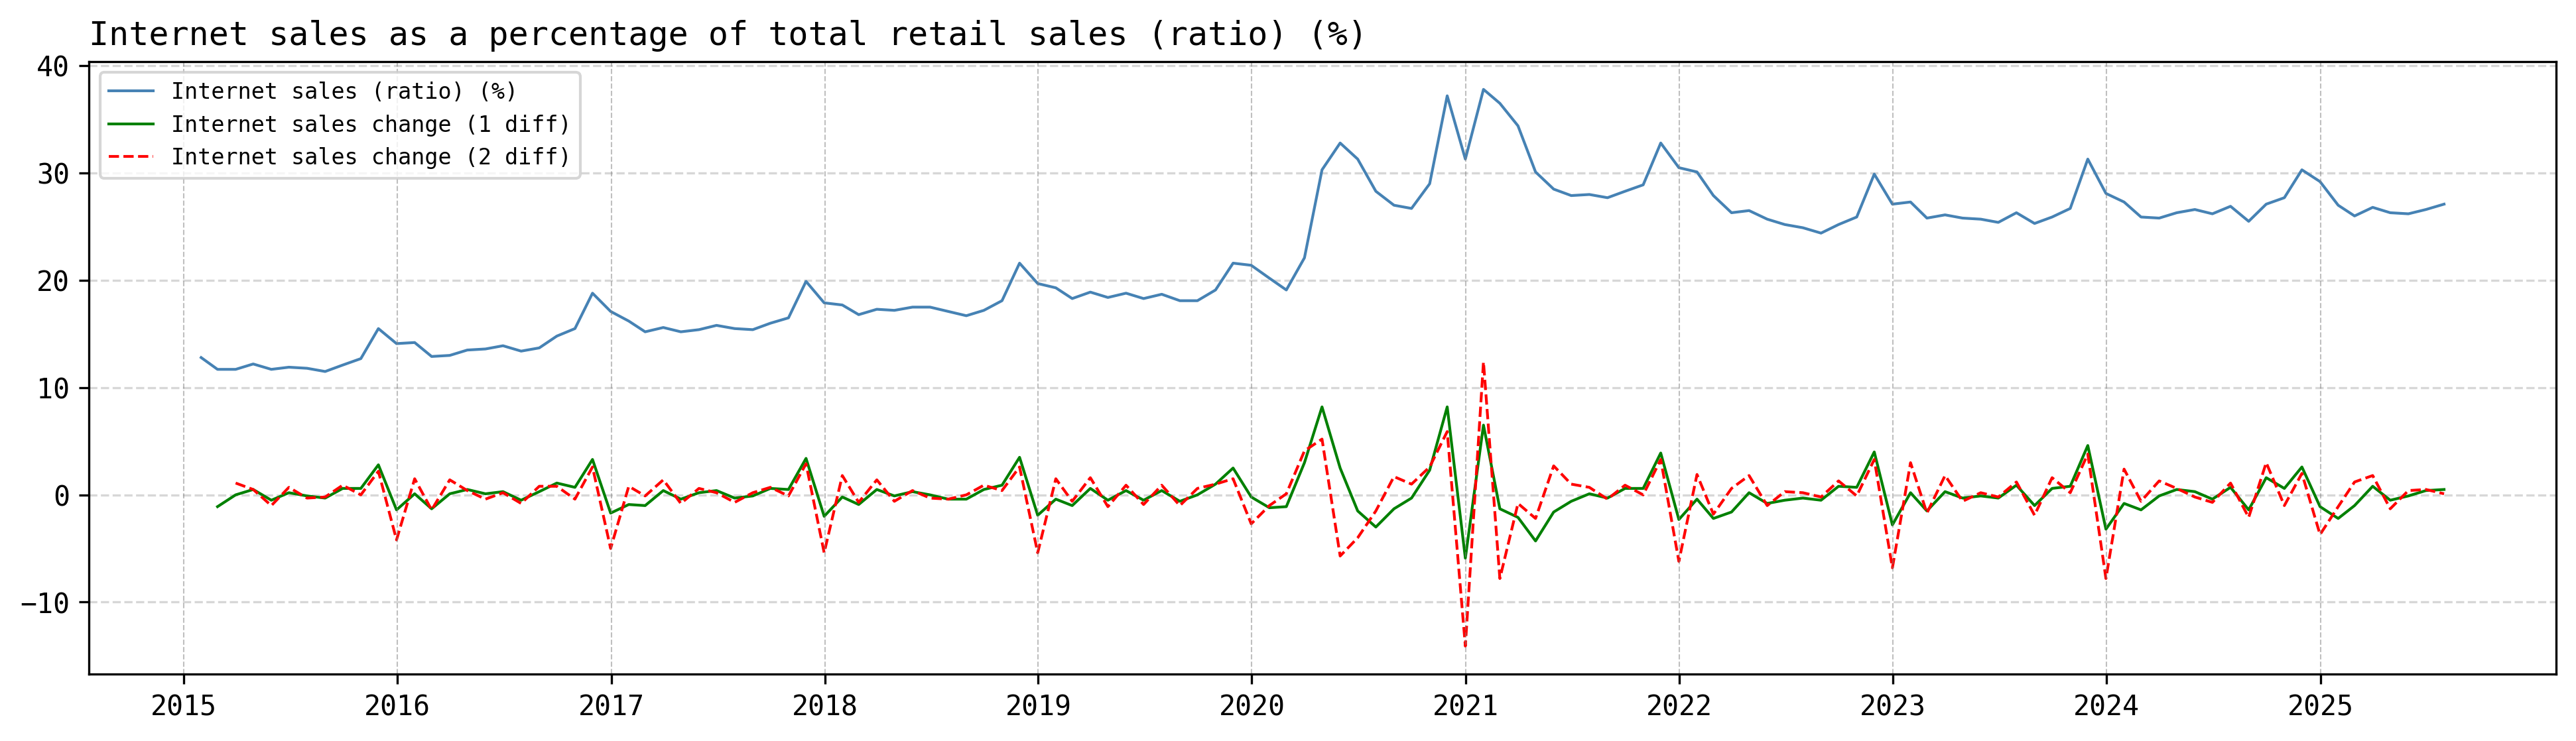

In [10]:
plot_df = pd.DataFrame({
    'date': df.index,
    'original': df['online_retail_sales_share'],
    'diff_1': df['online_retail_sales_share'].diff(),
    'diff_2': df['online_retail_sales_share'].diff().diff()
})

plt.figure(figsize=(16, 4), dpi=300)
ax = plt.gca()

# Plot with proper data alignment
ax.plot(plot_df['date'], plot_df['original'], color='steelblue', linewidth=1, label='Internet sales (ratio) (%)')
ax.plot(plot_df['date'], plot_df['diff_1'], color='green', linewidth=1, label='Internet sales change (1 diff)')
ax.plot(plot_df['date'], plot_df['diff_2'], color='red', linewidth=1, linestyle='--', label='Internet sales change (2 diff)')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# event_spans = add_event_spans(ax)

ax.legend(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Internet sales as a percentage of total retail sales (ratio) (%)', loc='left')
plt.show()

In [11]:
var_original = df['online_retail_sales_share'].var()
var_diff1 = df['online_retail_sales_share'].diff().var()
var_diff2 = df['online_retail_sales_share'].diff().diff().var()

print(f"Variance - Original: {var_original:.4f}")
print(f"Variance - 1st diff: {var_diff1:.4f}")
print(f"Variance - 2nd diff: {var_diff2:.4f}")

Variance - Original: 43.3922
Variance - 1st diff: 3.7314
Variance - 2nd diff: 8.1534


> Note: ADF/KFSS indicate 2nd differencing, however the variance for 1st differencing is lower. 1 or 2 unit roots.

## PELT (pruned exact linear time) & Chow Test

In [12]:
from ruptures import Pelt

In [13]:
data = df['online_retail_sales_share'].values

# 'rbf' = radial basis function kernel (good for general changes)
# 'l1' = L1 norm or 'l2' = L2 norm (good for mean changes)
# 'normal' = assumes Gaussian distribution
model_pelt = Pelt(model='l1', min_size=12, jump=1)  # min_size prevents very short segments

# Different penalty values to see sensitivity, the higher the penalty, the fewer changepoints detected
penalties = [10, 25, 50]
for pen in penalties:
    result = model_pelt.fit_predict(data, pen=pen)
    changepoints = result[:-1]
    print(f"Penalty {pen}: {len(result) - 1} changepoints at indices {result[:-1]} with dates {[df.index[i].strftime('%Y-%m-%d') for i in changepoints]}")

Penalty 10: 4 changepoints at indices [20, 34, 63, 85] with dates ['2016-09-30', '2017-11-30', '2020-04-30', '2022-02-28']


Penalty 25: 3 changepoints at indices [21, 63, 85] with dates ['2016-10-31', '2020-04-30', '2022-02-28']
Penalty 50: 2 changepoints at indices [21, 63] with dates ['2016-10-31', '2020-04-30']


In [14]:
# changepont to feed further into the chow test
result = model_pelt.fit(data).predict(pen=25)
changepoints = result[:-1]

In [15]:
import statsmodels.api as sm
from scipy import stats

y = df['online_retail_sales_share'].values
n = len(y)
trend = np.arange(n)  # Simple trend variable
dates = df.index

alpha_bonf = 0.05 / len(changepoints)
changepoints_tested = []

for k in changepoints:
    break_date = dates[k]

    # Create dummy: 0 before break, 1 from break onward
    D = np.zeros(n)
    D[k:] = 1

    # Create interaction term
    trend_interaction = trend * D

    # Model matrices
    X_restricted = sm.add_constant(trend)  # [constant, trend]
    X_unrestricted = sm.add_constant(np.column_stack([
        trend, D, trend_interaction
    ]))  # [constant, trend, dummy, trend*dummy]

    # Fit models
    res_r = sm.OLS(y, X_restricted).fit()    # Restricted: no break
    res_u = sm.OLS(y, X_unrestricted).fit()  # Unrestricted: break allowed

    # Chow F-statistic
    q = 2  # Number of restrictions (dummy + interaction)
    df1 = q
    df2 = res_u.df_resid

    f_stat = ((res_r.ssr - res_u.ssr) / df1) / (res_u.ssr / df2)
    p_val = 1 - stats.f.cdf(f_stat, df1, df2)

    print(f'Breakpoint index {k} → date {break_date.strftime("%Y-%m-%d")}')
    print(f'  Chow F({df1},{int(df2)}) = {f_stat:.3f}, p = {p_val:.4f}')

    if p_val < alpha_bonf:
        print("  → SIGNIFICANT after Bonferroni correction\n")
        changepoints_tested.append(k)
    else:
        print("  → Not significant after Bonferroni correction\n")

print(f"Significant breakpoints: {changepoints_tested}")

Breakpoint index 21 → date 2016-10-31
  Chow F(2,123) = 3.206, p = 0.0439
  → Not significant after Bonferroni correction

Breakpoint index 63 → date 2020-04-30
  Chow F(2,123) = 166.509, p = 0.0000
  → SIGNIFICANT after Bonferroni correction

Breakpoint index 85 → date 2022-02-28
  Chow F(2,123) = 55.767, p = 0.0000
  → SIGNIFICANT after Bonferroni correction

Significant breakpoints: [63, 85]


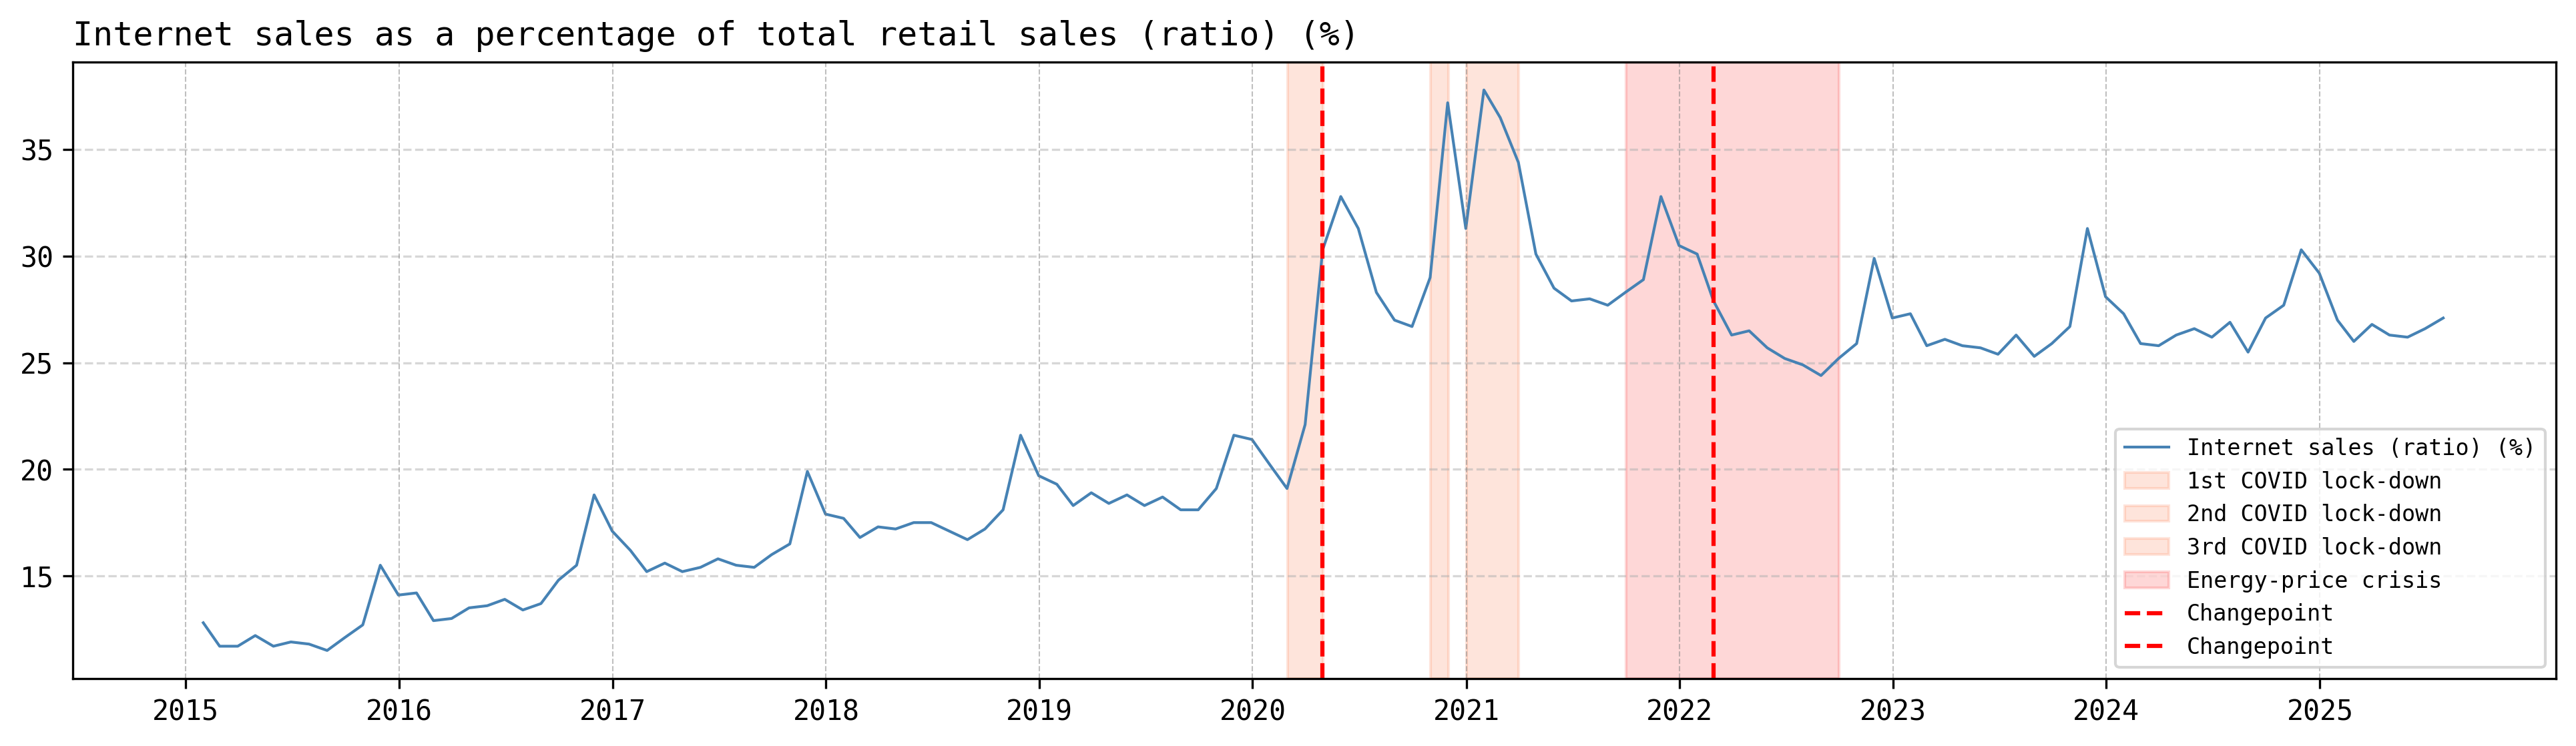

In [16]:
# Chart overlay with changepoints
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=df, x='date', y='online_retail_sales_share', linewidth=1, color='steelblue', label='Internet sales (ratio) (%)')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

event_spans = add_event_spans(ax)

# Change points
for cp in changepoints_tested:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', alpha=1, linewidth=1.5, label='Changepoint')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Internet sales as a percentage of total retail sales (ratio) (%)', loc='left')
plt.savefig('../outputs/figures/RSI_trend_changepoints.png', bbox_inches='tight', dpi=300)
plt.show()

> Note: identified checkpoints align with Covid-19 pandemic events

In [17]:
dates = df.index[changepoints_tested]
df['d_cov'] = (df.index >= dates[0]).astype(int)
df['d_post'] = (df.index >= dates[1]).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2015-01-31 to 2025-07-31
Freq: ME
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   online_retail_sales_share  127 non-null    float64
 1   cpi_inf                    127 non-null    float64
 2   rpi_ex_cpi                 127 non-null    float64
 3   eff_fx_inf                 127 non-null    float64
 4   cci                        127 non-null    float64
 5   boe_rate                   127 non-null    float64
 6   d_cov                      127 non-null    int64  
 7   d_post                     127 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 8.9 KB


## Markov regime-switching / no exogenous variables

In [18]:
from statsmodels.tsa.regime_switching import markov_regression

np.random.seed(1234)  # 1234

model_markov = markov_regression.MarkovRegression(
    endog=df['online_retail_sales_share'],
    k_regimes=2,
    trend='c',  # trend per regime 'c' = constant, 't' = linear trend, 'ct' = constant + linear trend
    switching_trend=True,   # Allow intercept to switch
    switching_variance=True,  # Allow variance to switch
    # switching_exog=False     # Allow time trend coefficient to switch
)

results_markov = model_markov.fit(
    em_iter=200,
    search_reps=100,         # More search repetitions
    search_iter=100,        # More iterations per search
    maxiter=5000,          # More EM iterations
    method='powell'
)

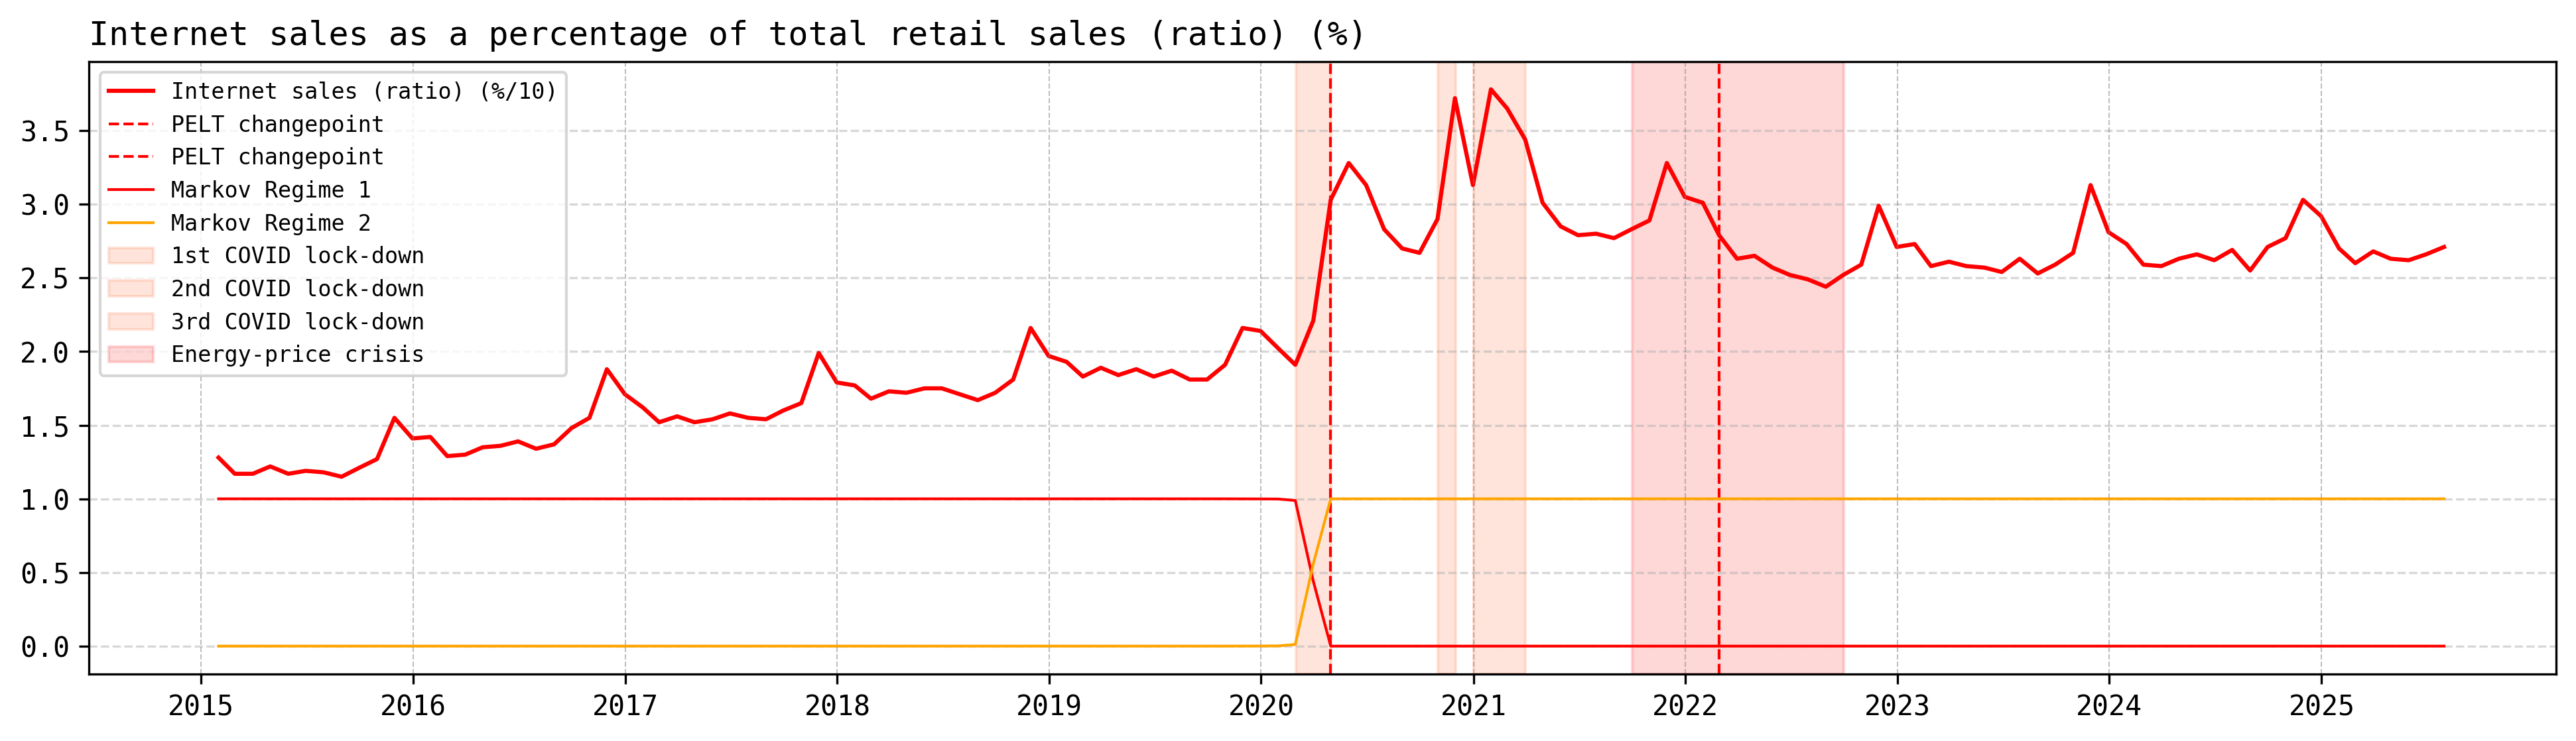

In [19]:
regime_probs = results_markov.smoothed_marginal_probabilities
regime_most_likely = np.argmax(regime_probs, axis=1)

# Chart overlay with changepoints
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=df, x='date', y=df['online_retail_sales_share'] / 10, linewidth=1.5, color='red', label='Internet sales (ratio) (%/10)')

# PELT changepoints
for cp in changepoints_tested:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', alpha=1, linewidth=1, label='PELT changepoint')

# Markov regime probabilities
ax.plot(regime_probs.iloc[:, 0], label='Markov Regime 1', color='red', linewidth=1)
ax.plot(regime_probs.iloc[:, 1], label='Markov Regime 2', color='orange', linewidth=1)
# ax.plot(regime_probs.iloc[:, 2], label='Markov Regime 3', color='green', linewidth=1)
# ax.plot(regime_probs.iloc[:, 3], label='Markov Regime 4', color='blue', linewidth=1)
# ax.plot(regime_probs.iloc[:, 4], label='Markov Regime 5', color='grey', linewidth=1)

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Internet sales as a percentage of total retail sales (ratio) (%)', loc='left')
plt.savefig('../outputs/figures/RSI_trend_changepoints.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
probs = results_markov.smoothed_marginal_probabilities
print(probs.describe())
print((probs > 0.5).sum())

                  0             1
count  1.270000e+02  1.270000e+02
mean   4.915496e-01  5.084504e-01
std    4.998483e-01  4.998483e-01
min    1.198767e-15  4.590425e-11
25%    4.027416e-08  3.821563e-08
50%    3.976676e-06  9.999960e-01
75%    1.000000e+00  1.000000e+00
max    1.000000e+00  1.000000e+00
0    62
1    65
dtype: int64


> Note: Markov w/o exog only identifies 2 regimes. Forcing more reveales changepoint in 2017 which does not make sense. 2 PELT changepoints identified but only if the model is overfitted.

# 2. Save data

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2015-01-31 to 2025-07-31
Freq: ME
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   online_retail_sales_share  127 non-null    float64
 1   cpi_inf                    127 non-null    float64
 2   rpi_ex_cpi                 127 non-null    float64
 3   eff_fx_inf                 127 non-null    float64
 4   cci                        127 non-null    float64
 5   boe_rate                   127 non-null    float64
 6   d_cov                      127 non-null    int64  
 7   d_post                     127 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 8.9 KB


In [26]:
metadata = {
    'description': 'Online retail share forecasting with economic indicators as features',
    'target_column': 'online_retail_sales_share',
    'feature_columns': ['cpi_inf', 'rpi_ex_cpi', 'eff_fx_inf', 'cci', 'boe_rate', 'd_cov', 'd_post'],
    'frequency': 'M',
    'first_obs': df.index[0],
    'last_obs': df.index[-1],
    'break_idx': [63, 85],
    'break_dates': [df.index[i] for i in [63, 85]]
}

file_to_save = processed_data_dir / "meta_data.pkl"
with open(file_to_save, 'wb') as f:
    pickle.dump(metadata, f)

In [ ]:
file_to_save = processed_data_dir / "model_data.pkl"
df.to_pickle(file_to_save)